# Intro and function definitions

We have 108 databases of different tissue/seed/method combinations. Now we'd like to know how much of the genome we cover in each case. 

In [29]:
# Import packages
library('dplyr') # For dataframe manipulation
library('GenomicRanges') # For doing overlaps and reductions
library('purrr') # For combining dataframes quickly
library('BiocParallel') # For parallel computations
library('RPostgreSQL') # For reading from databases
library('ggpubr') # For plotting

## Function Definitions

In [ ]:
# First, create a function that reads the FIMO data for one chromosome
getRegionsForChrom <- function(chromosome){
    
    fimo.conn <- dbConnect(PostgreSQL(),
                       user = "trena",
                       password = "trena",
                       port = "5432",
                       host = "khaleesi",
                       dbname = "fimo"                    
                      )
    
    # Print out what chromosome we're using
    to.print <- sprintf("Working on %s", chromosome)
    print(to.print)
    # Make a string for the chromosome
    query <- sprintf("select chrom, start, endpos from fimo_hg38 where chrom = '%s';",
                     chromosome)
    fimo.data <- dbGetQuery(fimo.conn, query)
    dbDisconnect(fimo.conn)
    
    # Print out the number of records retrieved
    to.print <- sprintf("%d records retrieved for %s", nrow(fimo.data), chromosome)
    return(fimo.data)
}

In [61]:
# Function for counting coverage as % of human genome, given a genomic range
calculateGenomeCoverage <- function(my.range){
    
    # Use the "reduce" function to calculate the total areas covered
    reduced.range <- GenomicRanges::reduce(my.range)
    
    # Sum the areas using the "width" operator to get each area
    total.bp <- sum(as.numeric(width(reduced.range)))
    
    # Divide by total human genome length and return result (a decimal)
    # my.coverage <- total.bp/3253848404
    return(total.bp)
}

In [ ]:
# Make a function that takes tissue name and figures out the pathway to its footprints
compileFootprintPaths <- function(tissue){
    
    # Create the 4 strings from the tissue
    hint.20 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_hint_20")
    hint.16 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_hint_16")
    well.20 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_wellington_20")
    well.16 <- paste0("/ssd/mrichard/data/footprints/",tissue,"_wellington_16")
    
    # Create all the paths
    hint.20.paths <- list.files(hint.20)
    hint.20.paths <- file.path(hint.20, hint.20.paths)
    
    hint.16.paths <- list.files(hint.16)
    hint.16.paths <- file.path(hint.16, hint.16.paths)
    
    well.20.paths <- list.files(well.20)
    well.20.paths <- file.path(well.20, well.20.paths)
    
    well.16.paths <- list.files(well.16)
    well.16.paths <- file.path(well.16, well.16.paths)
    
    # Stick the paths together and return them
    all.paths <- c(hint.20.paths,
                   hint.16.paths,
                   well.20.paths,
                   well.16.paths
                  )
    
    return(all.paths)
}

In [ ]:
# Define a function that takes pathways and uses them to read FPs
readFootprintTable <- function(fp.path){
    tbl <- read.table(fp.path, sep = "\t", as.is = TRUE)
    colnames(tbl) <- c("chrom", "start", "end", "name", "score", "strand")
    return(tbl)
}

In [ ]:
# Define a function that takes a list of footprint dataframes and makes it into a genomic range
footprintsToGenomicRange <- function(fp.list){
    
    # Remove the non-start/end/stop columns
    to.keep <- c("chrom","start","end")
    fp.list <- lapply(fp.list,dplyr::select, one_of(to.keep))
    
    # Collapse into one data frame
    fp.df <- purrr::reduce(fp.list, dplyr::union)
    
    # Convert it into a genomic range
    my.gr <- with(fp.df, GRanges(seqnames=chrom, IRanges(start=start, end=end)))
    
    return(my.gr)
}

In [ ]:
# Build a function that takes the tissue and goes all the way through to coverage
coverageFromTissue <- function(tissue){
    
    # First find the footprints
    fp <- compileFootprintPaths(tissue)
    
    # Then use a parallel process to read all the footprints
    my.message <- sprintf("Reading %d files for %s", length(fp), tissue)
    print(my.message)
    register(MulticoreParam(workers = 30, stop.on.error = TRUE, log = FALSE), default = TRUE)
    fp.list <- bptry(bplapply(fp, readFootprintTable))
    
    # Turn the footprint list into a genomic range
    fp.gr <- footprintsToGenomicRange(fp.list)
    rm(fp.list)
    
    # Find the coverage
    fp.coverage <- calculateGenomeCoverage(fp.gr)
    return(fp.coverage)
}

# Part 1: Calculate total overlap of FIMO

The FIMO database we use is massive and contains a lot of ranges; however, it doesn't cover EVERYTHING. We want to:

1. Read FIMO into a data frame from its database
2. Turn FIMO into a GenomicRanges object
3. Use our function to determine how much of the genome it covers

Unfortunately, we can't read it all at once, so let's see if we can break it into chromosomes and read it that way! 

In [53]:
# Test on just the y chromosome
chrom <- "Y"
system.time(test <- getRegionsForChrom(chrom))

[1] "Working on Y"


   user  system elapsed 
  3.516   0.252   8.716 

In [55]:
chroms <- c(1:22, "X","Y", "MT")
register(MulticoreParam(workers = 25, stop.on.error = TRUE, log = TRUE), default = TRUE)
   
# Run it
system.time(all.chroms.list <- bptry(bplapply(chroms, getRegionsForChrom)))

############### LOG OUTPUT ###############
Task: 25
Node: 25
Timestamp: 2017-10-19 08:02:58
Success: TRUE
Task duration:
   user  system elapsed 
  0.012   0.004   2.298 
Memory used:
           used  (Mb) gc trigger   (Mb)   max used    (Mb)
Ncells  2020960 108.0   55774197 2978.7  110856919  5920.4
Vcells 89422924 682.3 1129456322 8617.1 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on MT"
############### LOG OUTPUT ###############
Task: 24
Node: 24
Timestamp: 2017-10-19 08:03:11
Success: TRUE
Task duration:
   user  system elapsed 
  4.040   1.804  13.263 
Memory used:
            used  (Mb) gc trigger   (Mb)   max used    (Mb)
Ncells   2021000 108.0   44619357 2383.0  110856919  5920.4
Vcells 109469887 835.2  903565057 6893.7 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on Y"
############### LOG OUTPUT ###############
Task: 21
Node: 21
Timestamp: 2017-10-19 08:05:28
Success: TRUE
Task duration:
   user  system elapsed 
  8.956   8.768 148.634 

############### LOG OUTPUT ###############
Task: 4
Node: 4
Timestamp: 2017-10-19 08:10:43
Success: TRUE
Task duration:
   user  system elapsed 
 43.104  58.248 418.807 
Memory used:
             used    (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells    2021666   108.0    5988707   319.9  110856919  5920.4
Vcells 2048686629 15630.3 2985470128 22777.4 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on 4"
############### LOG OUTPUT ###############
Task: 1
Node: 1
Timestamp: 2017-10-19 08:11:05
Success: TRUE
Task duration:
   user  system elapsed 
 49.032  76.304 461.441 
Memory used:
             used    (Mb) gc trigger    (Mb)   max used    (Mb)
Ncells    2021701   108.0    5988707   319.9  110856919  5920.4
Vcells 2265338952 17283.2 3582644153 27333.5 2757461726 21037.8
Log messages:
stderr and stdout:
[1] "Working on 1"
############### LOG OUTPUT ###############
Task: 2
Node: 2
Timestamp: 2017-10-19 08:11:37
Success: TRUE
Task duration:
   user  system elapsed 
 51.

   user  system elapsed 
159.120 147.420 566.772 

In [56]:
# Convert to a DF
full.fimo <- bind_rows(all.chroms.list)

In [57]:
# Size is??
dim(full.fimo)

[1] 1344953740          3

Make it into a GRanges object

In [58]:
gr.fimo <- with(full.fimo, GRanges(seqnames=chrom, IRanges(start=start, end=endpos)))

Find the coverage

In [62]:
system.time(fimo.coverage <- calculateGenomeCoverage(gr.fimo))

   user  system elapsed 
206.532   3.696 210.247 

In [63]:
100* fimo.coverage/3253848404

[1] 78.13244

# Part 2: Calculate the coverage for each tissue

Find the coverage for each tissue, using all methods AND seeds for each tissue. Do this using lapply; don't use bplapply, as that's already being used in the inner functions

In [18]:
all.tissues <- c("adrenal_gland",
                 "blood_vessel",
                 "bone_element",
                 "brain",
                 "bronchus",
                 "esophagus",
                 #"extraembryonic_structure",
                 "eye",
                 "gonad",
                 "heart",
                 "kidney",
                 "large_intestine",
                 "liver",
                 "lung",
                 "lymphatic_vessel",
                 "lymphoblast",
                 "mammary_gland",
                 "mouth",
                 "muscle_organ",
                 "pancreas",
                 "prostate_gland",
                 "skin",
                 "spinal_cord",
                 "stomach",
                 "thyroid_gland",
                 "tongue",
                 "urinary_bladder"                
                )
length(all.tissues)

[1] 26

In [19]:
# Note: This takes ~4.5 hours
system.time(all.widths <- lapply(all.tissues, coverageFromTissue))

[1] "Reading 12 files for adrenal_gland"
[1] "Reading 40 files for blood_vessel"
[1] "Reading 4 files for bone_element"
[1] "Reading 116 files for brain"
[1] "Reading 8 files for bronchus"
[1] "Reading 8 files for esophagus"
[1] "Reading 32 files for eye"
[1] "Reading 10 files for gonad"
[1] "Reading 30 files for heart"
[1] "Reading 32 files for kidney"
[1] "Reading 20 files for large_intestine"
[1] "Reading 10 files for liver"
[1] "Reading 28 files for lung"
[1] "Reading 8 files for lymphatic_vessel"
[1] "Reading 84 files for lymphoblast"
[1] "Reading 8 files for mammary_gland"
[1] "Reading 16 files for mouth"
[1] "Reading 14 files for muscle_organ"
[1] "Reading 8 files for pancreas"
[1] "Reading 8 files for prostate_gland"
[1] "Reading 184 files for skin"
[1] "Reading 8 files for spinal_cord"
[1] "Reading 4 files for stomach"
[1] "Reading 12 files for thyroid_gland"
[1] "Reading 8 files for tongue"
[1] "Reading 4 files for urinary_bladder"


     user    system   elapsed 
14027.048   447.392 15432.861 

In [22]:
tissue.coverage <- data_frame(Tissue = all.tissues,
                              Total.Width = unlist(all.widths),
                              Coverage = 100*Total.Width/3253848404
                             )

In [24]:
tissue.coverage %>% arrange(desc(Coverage))

Tissue,Total.Width,Coverage
brain,485325656,14.915435
skin,318498047,9.788349
lymphoblast,289361515,8.892901
eye,207309541,6.371211
heart,193291371,5.940393
kidney,183101528,5.627230
lung,166876505,5.128589
blood_vessel,147439372,4.531231
large_intestine,143353494,4.405660
mouth,127645515,3.922909


In [26]:
saveRDS(tissue.coverage, "./allCoverageWOExtraembryonic.RDS")

In [27]:
# Load the DF if necessary
#tissue.coverage <- readRDS("./allCoverageWOExtraembryonic.RDS")

png 
  2

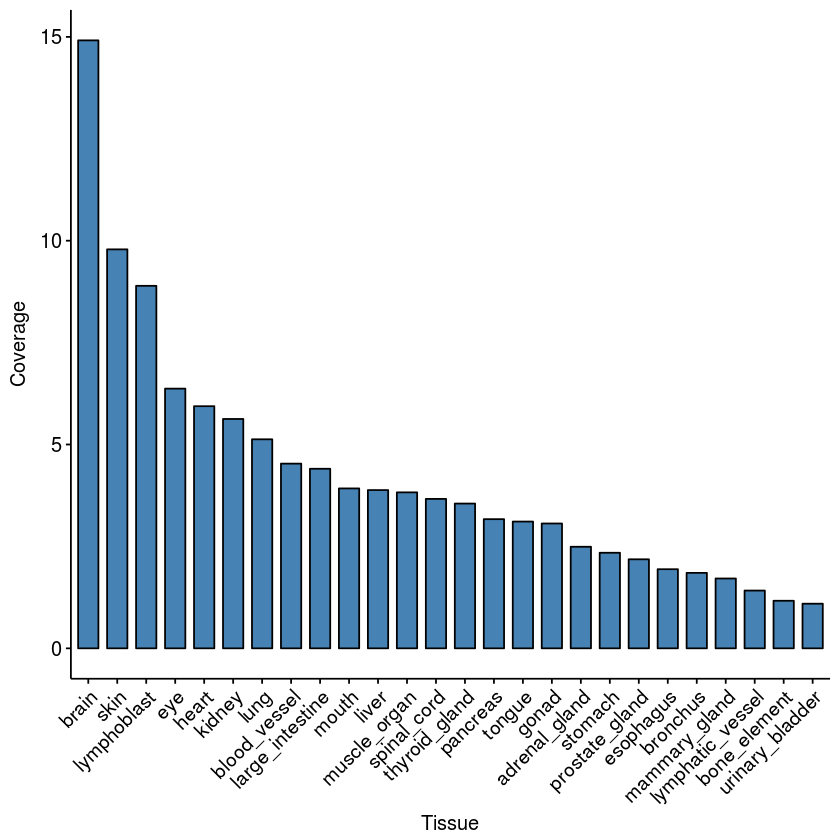

In [65]:
# Plot it
tissue.coverage %>% ggbarplot(x = "Tissue",
                              y = "Coverage",
                              fill = "steelblue",
                              x.text.angle = 45,
                              sort.val = "desc"                              
                             ) -> coverage.plot

# Save to a figure
png("./coveragePlot.png")
coverage.plot
dev.off()

# Show it
coverage.plot
